# Análise Temporal: Padrões, Tendências e Sazonalidade

## 🎯 Objetivo da Aula
Aprender a manipular dados temporais, criar colunas úteis de tempo, e detectar padrões como **tendências de longo prazo**, **picos sazonais** e **comportamentos recorrentes** em séries temporais.

## 🧠 O que é uma série temporal?
Uma **série temporal** é um conjunto de dados organizados por ordem cronológica, geralmente com datas associadas a algum valor.

Exemplos comuns:
- Vendas por dia ou mês
- Acessos ao site por semana
- Churn mensal de clientes
- Temperatura diária

## 🔧 Criando uma série temporal fictícia de vendas

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

np.random.seed(42)
datas = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
n = len(datas)
tendencia = np.linspace(100, 500, n)
sazonalidade_anual = 50 * np.sin(2 * np.pi * datas.dayofyear / 365)
sazonalidade_semanal = 20 * np.sin(2 * np.pi * datas.dayofweek / 7)
ruido = np.random.normal(0, 15, n)
vendas = tendencia + sazonalidade_anual + sazonalidade_semanal + ruido

df = pd.DataFrame({
    'Data': datas,
    'Vendas': vendas
})

df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)

# Verifique que o índice agora é DatetimeIndex:
print(type(df.index))      # deve exibir: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
print(df.index[:3], '\n')  # mostrando as três primeiras datas

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03'], dtype='datetime64[ns]', name='Data', freq=None) 



## 📈 Visualizando a série temporal

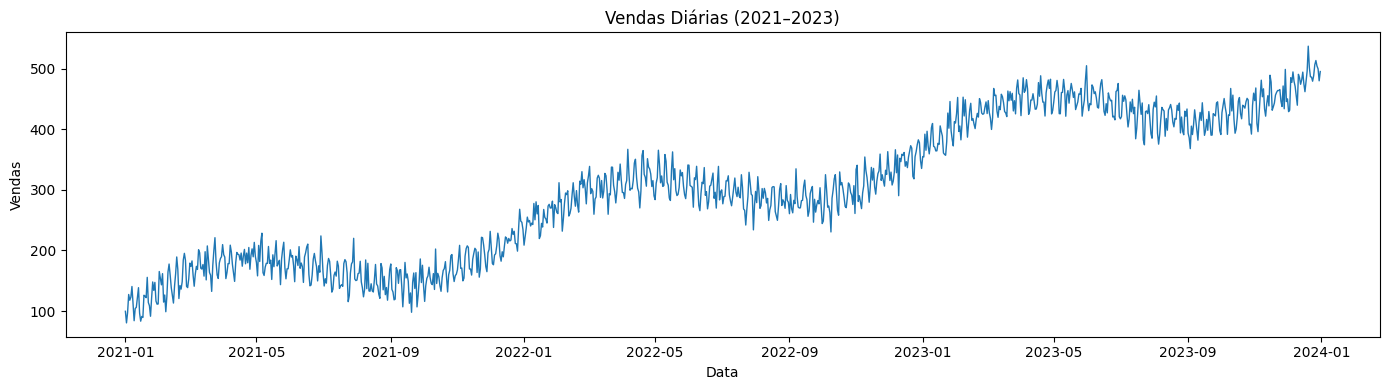

In [22]:
#Série temporal completa
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['Vendas'], color='tab:blue', linewidth=1)
plt.title('Vendas Diárias (2021–2023)')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.tight_layout()
plt.show()


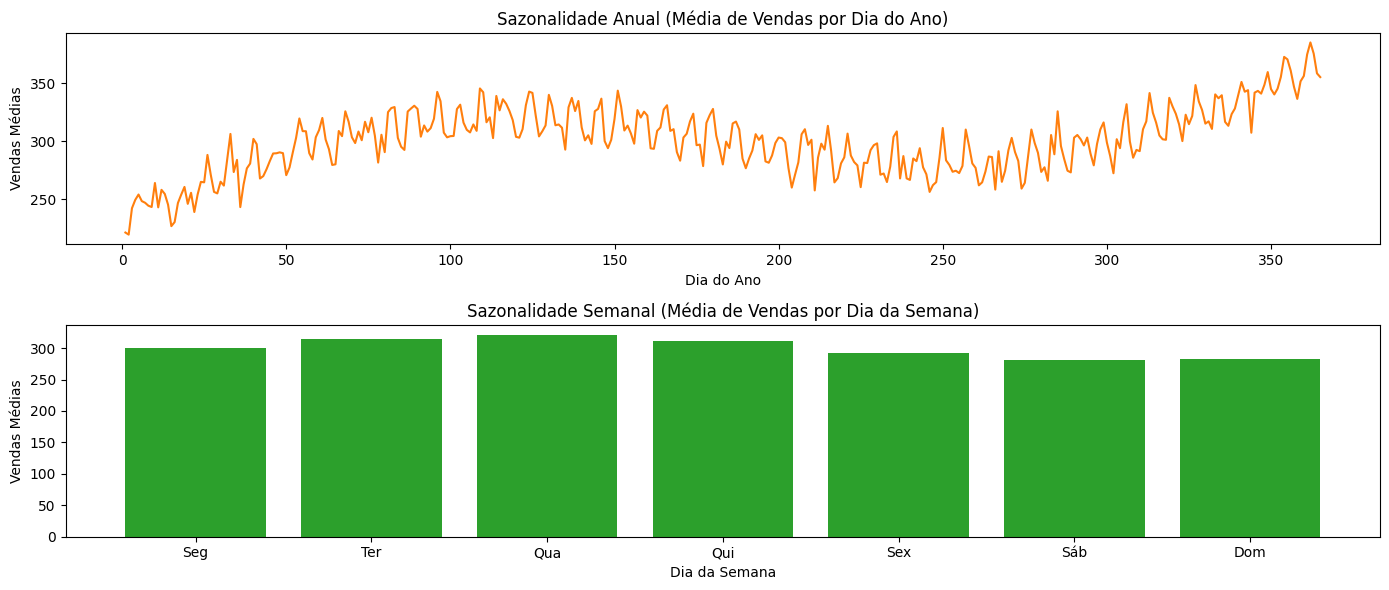

In [24]:
# Calcular sazonalidade anual e semanal a partir do índice datetime
# a) Sazonalidade anual: média de vendas por dia do ano (1–365)
df['Dia_do_Ano'] = df.index.dayofyear
sazonal_anual = df.groupby('Dia_do_Ano')['Vendas'].mean()

# b) Sazonalidade semanal: média de vendas por dia da semana (0=Segunda … 6=Domingo)
df['Dia_da_Semana'] = df.index.dayofweek
sazonal_semanal = df.groupby('Dia_da_Semana')['Vendas'].mean()

# Plotar as duas sazonalidades
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].plot(sazonal_anual.index, sazonal_anual.values, color='tab:orange')
axes[0].set_title('Sazonalidade Anual (Média de Vendas por Dia do Ano)')
axes[0].set_xlabel('Dia do Ano')
axes[0].set_ylabel('Vendas Médias')

dias = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
axes[1].bar(dias, sazonal_semanal.values, color='tab:green')
axes[1].set_title('Sazonalidade Semanal (Média de Vendas por Dia da Semana)')
axes[1].set_xlabel('Dia da Semana')
axes[1].set_ylabel('Vendas Médias')

plt.tight_layout()
plt.show()


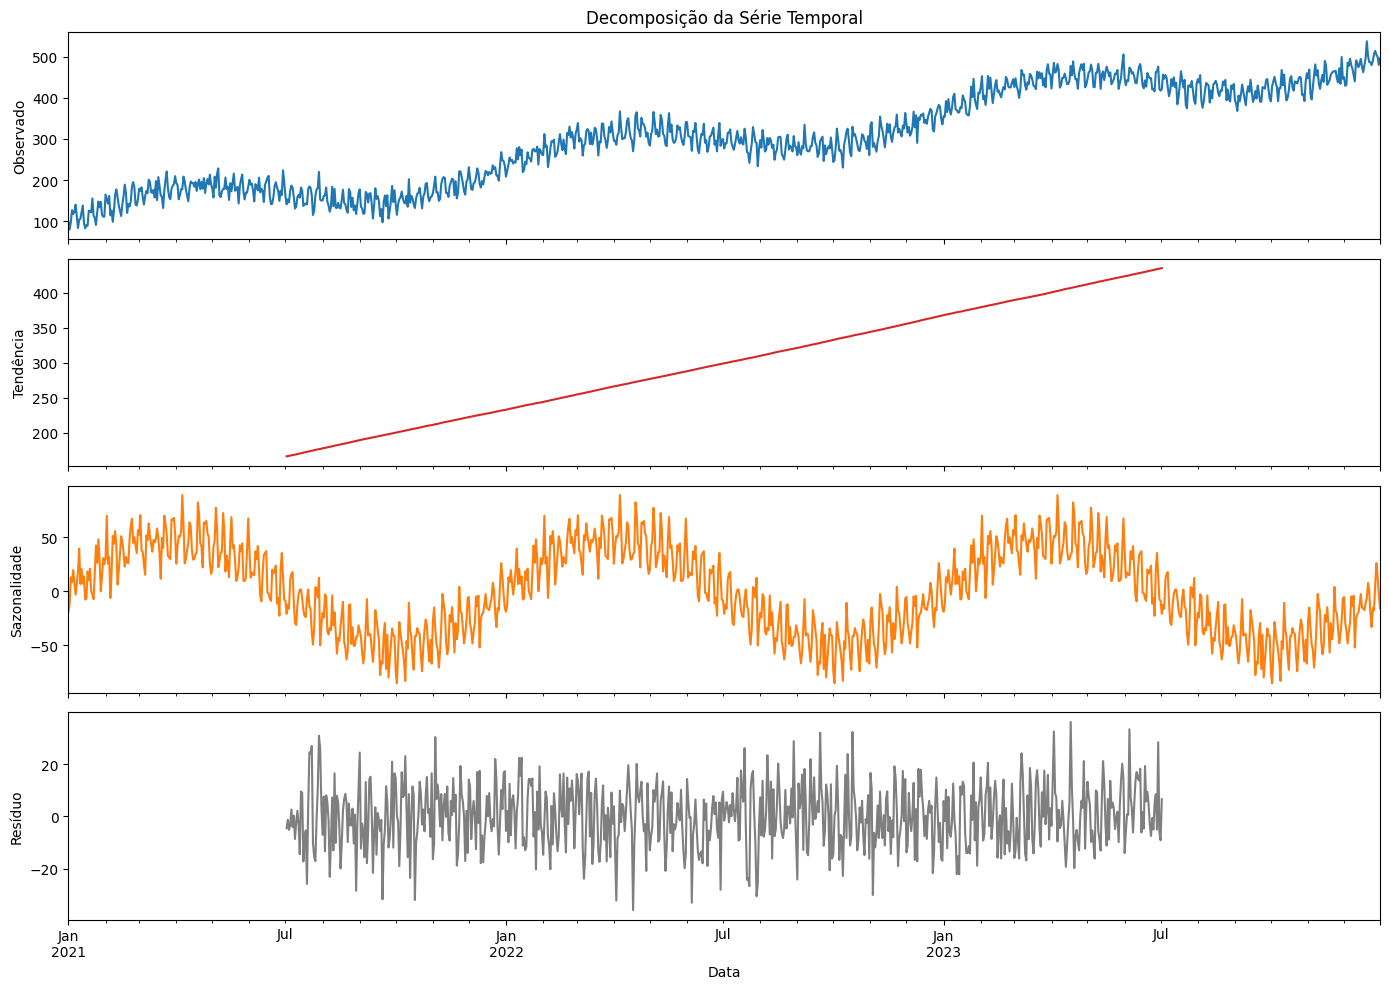

In [4]:
# Decomposição clássica (tendência + sazonalidade + resíduo)
decompose_result = seasonal_decompose(df['Vendas'], model='additive', period=365)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decompose_result.observed.plot(ax=ax1, legend=False, color='tab:blue')
ax1.set_ylabel('Observado')
ax1.set_title('Decomposição da Série Temporal')

decompose_result.trend.plot(ax=ax2, legend=False, color='tab:red')
ax2.set_ylabel('Tendência')

decompose_result.seasonal.plot(ax=ax3, legend=False, color='tab:orange')
ax3.set_ylabel('Sazonalidade')

decompose_result.resid.plot(ax=ax4, legend=False, color='tab:gray')
ax4.set_ylabel('Resíduo')
ax4.set_xlabel('Data')

plt.tight_layout()
plt.show()

## ✅ Conclusão
- Dados temporais exigem manipulação especial com datas.
- Criar colunas como mês, dia da semana e semana do ano permite **detectar padrões úteis**.
- A média móvel ajuda a observar **tendências de longo prazo**.
- Boxplots e médias por agrupamentos revelam **sazonalidade e ciclos comportamentais**.

## 🔮 Previsão com SARIMAX
Vamos usar o modelo **SARIMAX (AutoRegressive Integrated Moving Average)**

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [27]:

# 2) Dividir em treino e teste (últimos 180 dias para teste)
corte = df.index[-180]
train = df[:corte].copy()
test  = df[corte + pd.Timedelta(days=1):].copy()


####🔹 Componentes Não Sazonais (ARIMA):

p (Auto-Regressive – AR)
Número de defasagens (lags) da variável dependente a serem incluídas no modelo.
Ex: se p=1, o modelo usa o valor anterior da série para prever o atual.

d (Differencing – I)
Número de vezes que a série precisa ser diferenciada para se tornar estacionária (remover tendência).
Ex: d=1 → subtrai o valor anterior de cada ponto da série.

q (Moving Average – MA)
Número de defasagens dos erros passados (resíduos) a serem incluídos no modelo.


####🔸 Componentes Sazonais (SARIMA):
P (Seasonal AR)
Número de lags sazonais a serem considerados.

D (Seasonal Differencing)
Quantas vezes a série precisa ser diferenciada sazonalmente.

Q (Seasonal MA)
Número de lags dos erros sazonais (resíduos sazonais).

s (Sazonalidade)
O período da sazonalidade.
Ex: s=12 para dados mensais com padrão anual, s=7 para dados diários com padrão semanal.

In [28]:
# Ajustando o modelo SARIMAX
# ordem = (p, d, q) / sazonalidade = (P, D, Q, S)
model = SARIMAX(train['Vendas'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [29]:
# Previsão
forecast = results.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [30]:
# Calcular R²
r2 = r2_score(test['Vendas'], predicted_mean)
print(f'R²: {r2:.4f}')

R²: -1.5559


In [31]:
# Avaliação do modelo
rmse = np.sqrt(mean_squared_error(test['Vendas'], predicted_mean))
print(f'RMSE: {rmse:.2f}')

RMSE: 51.84


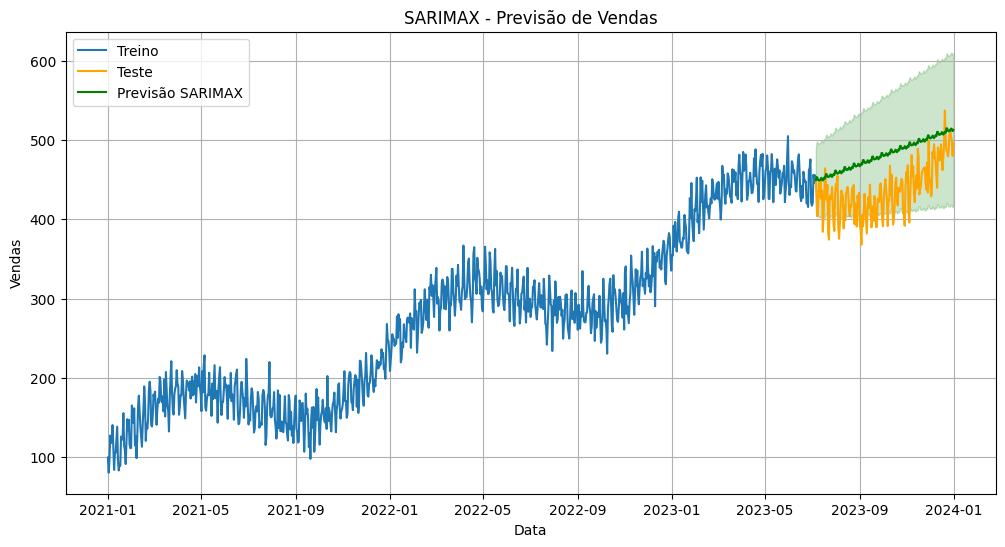

In [32]:
# Visualização
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Vendas'], label='Treino')
plt.plot(test.index, test['Vendas'], label='Teste', color='orange')
plt.plot(test.index, predicted_mean, label='Previsão SARIMAX', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMAX - Previsão de Vendas')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.grid(True)
plt.show()

## Prophet

In [33]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [34]:
# Criando dados simulados com tendência e sazonalidade
np.random.seed(42)
datas = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
tendencia = np.linspace(100, 400, len(datas))
sazonalidade = 30 * np.sin(2 * np.pi * datas.dayofyear / 365)
ruido = np.random.normal(0, 20, len(datas))
vendas = tendencia + sazonalidade + ruido
df = pd.DataFrame({'ds': datas, 'y': vendas})

In [35]:
# Instanciando e treinando o modelo Prophet
modelo = Prophet()
modelo.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpybggl82j/ark0txzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpybggl82j/zmgmuwrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58741', 'data', 'file=/tmp/tmpybggl82j/ark0txzk.json', 'init=/tmp/tmpybggl82j/zmgmuwrl.json', 'output', 'file=/tmp/tmpybggl82j/prophet_model7_dwws3u/prophet_model-20250602222019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
# Gerando previsões para os próximos 90 dias
futuro = modelo.make_future_dataframe(periods=90)
forecast = modelo.predict(futuro)

In [37]:
# Avaliando RMSE no período histórico
df_merged = pd.merge(df, forecast[['ds', 'yhat']], on='ds')
rmse = sqrt(mean_squared_error(df_merged['y'], df_merged['yhat']))
print("RMSE:", rmse)

RMSE: 19.30746672264981


In [38]:
mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])
r2 = r2_score(df_merged['y'], df_merged['yhat'])

print("MAE:", mae)
print("R²:", r2)

MAE: 15.334991786772687
R²: 0.950608175706663


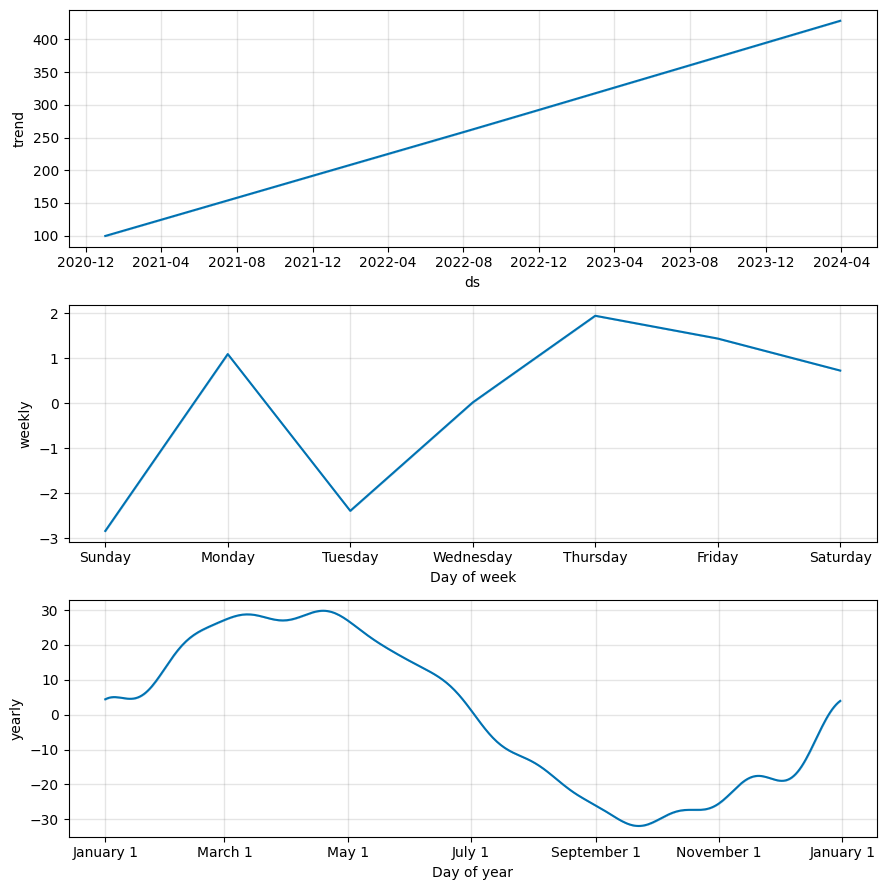

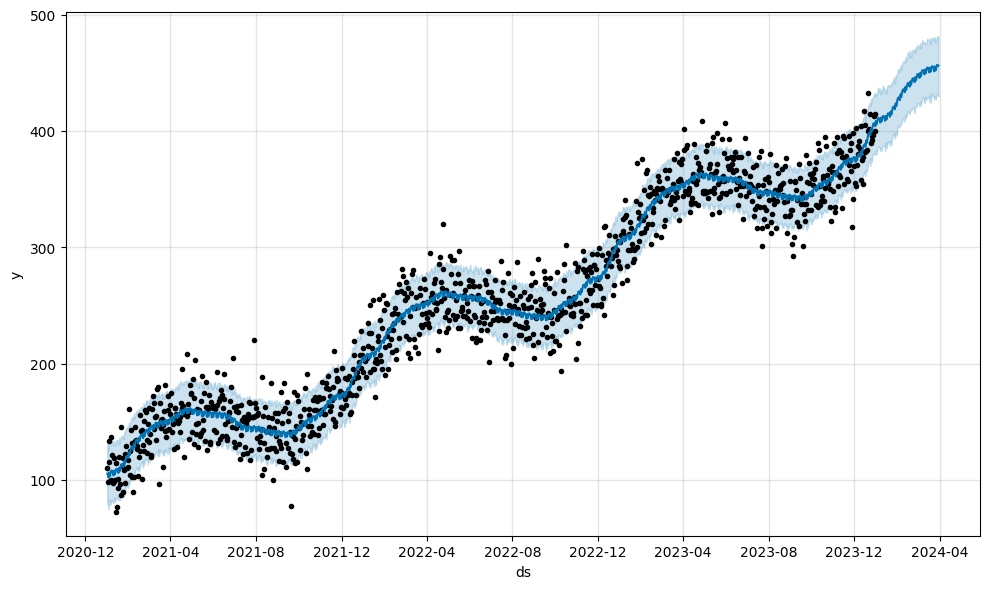

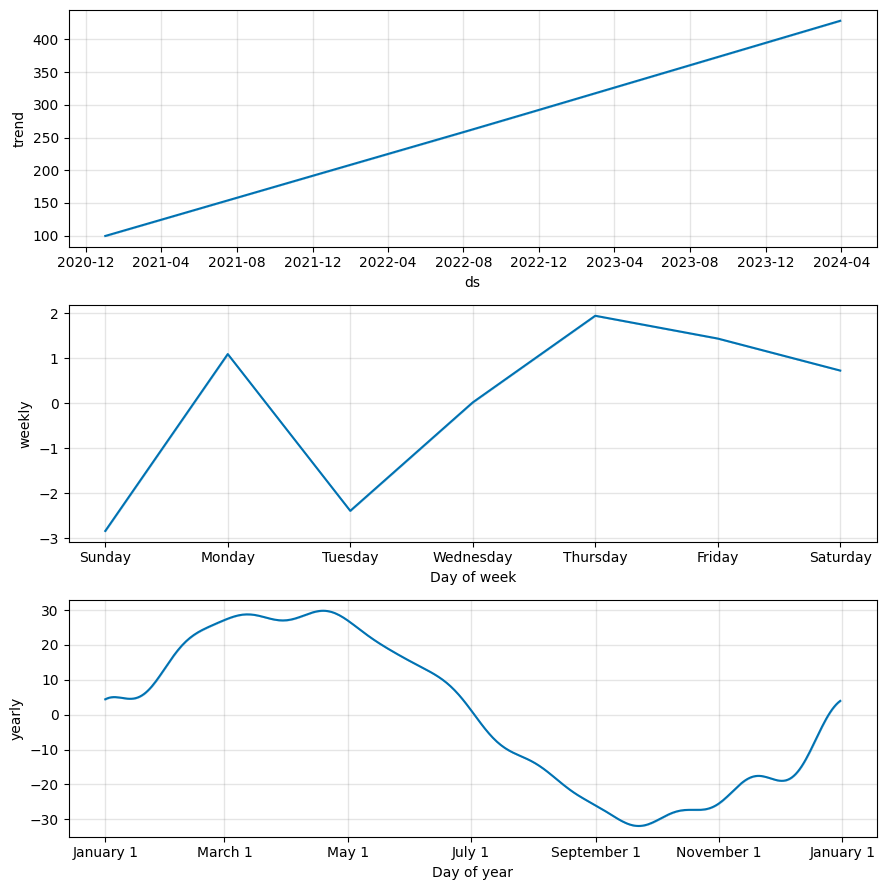

In [39]:
# Plotando
modelo.plot(forecast)
modelo.plot_components(forecast)

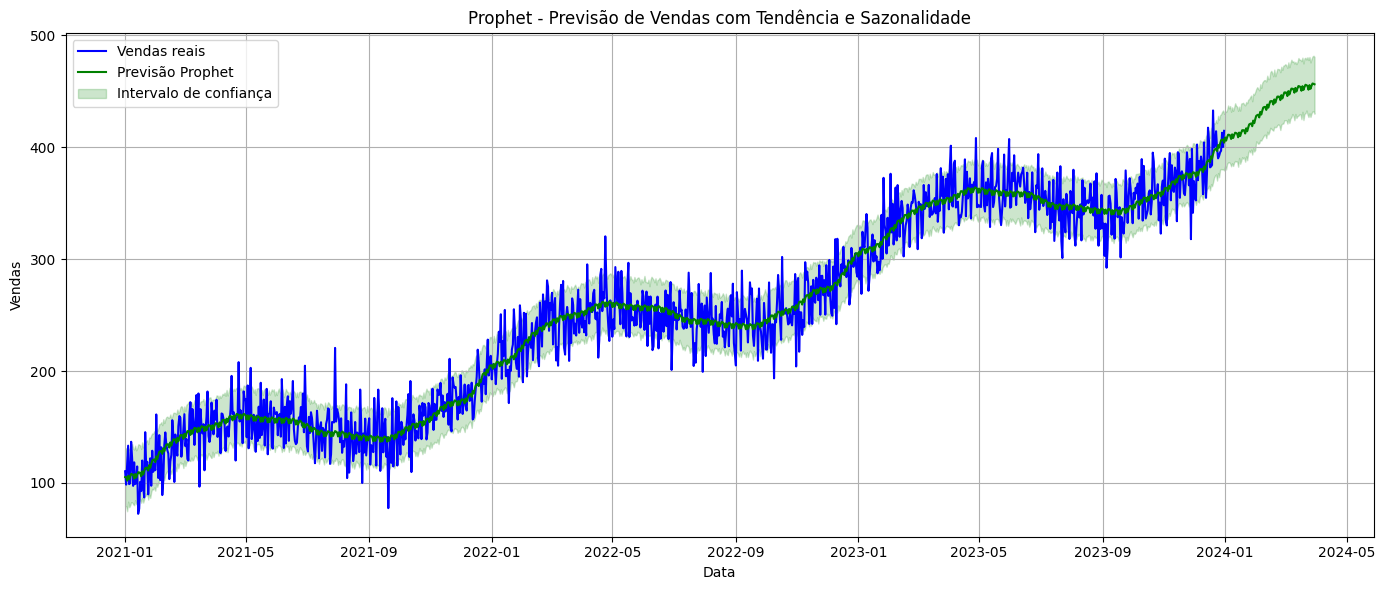

In [40]:
# Plot da previsão do Prophet com série histórica
plt.figure(figsize=(14, 6))

# Série histórica
plt.plot(df['ds'], df['y'], label='Vendas reais', color='blue')

# Previsão (yhat)
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão Prophet', color='green')

# Faixa de incerteza (intervalo de confiança)
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='green', alpha=0.2, label='Intervalo de confiança')

# Destaques visuais
plt.title('Prophet - Previsão de Vendas com Tendência e Sazonalidade')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ Conclusão Final
- ARIMA é um modelo poderoso para prever séries temporais com tendência.
- A função `auto_arima()` ajuda a identificar automaticamente os melhores parâmetros.
- A previsão pode ser usada para planejamento, alocação de recursos e tomada de decisão estratégica.